# Train a CNN on LSE cycles for age prediction from gait (ages are binned)

In [1]:
# Imports
import tables
import os
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
np.random.seed(42)

import threading
import pickle
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Input, BatchNormalization, Permute, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Activation, Conv2D
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.utils import to_categorical

from sklearn.utils import class_weight

Using TensorFlow backend.


In [3]:
# =============================================================================
# PARAMETERS
# =============================================================================

#File locations
output_dir = "/scratch/PI/euan/projects/mhc/code/daniel_code/results"
label_table_file = "/scratch/PI/euan/projects/mhc/code/daniel_code/tables/all.tsv"
train_data_path = r"/scratch/PI/euan/projects/mhc/code/daniel_code/data/age_cycles.hdf5"

#Training metrics
from concise.metrics import tpr, tnr, fpr, fnr, precision, f1
model_metrics = ['accuracy',tpr,tnr,fpr,fnr,precision,f1]

#Training parameters
batch_size = 512
canMultiprocess = False

/scratch/users/danjwu/miniconda3/lib/python3.6/site-packages/concise/utils/plot.py:115: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  min_coords = np.vstack(data.min(0) for data in polygons_data).min(0)
/scratch/users/danjwu/miniconda3/lib/python3.6/site-packages/concise/utils/plot.py:116: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  max_coords = np.vstack(data.max(0) for data in polygons_data).max(0)


# Data visualization and processing

In [3]:
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    print(file)

/scratch/PI/euan/projects/mhc/code/daniel_code/data/age_cycles.hdf5 (File) 'cycles'
Last modif.: 'Fri Jul 12 11:57:58 2019'
Object Tree: 
/ (RootGroup) 'cycles'
/data (EArray(300438, 100, 4)) ''
/labels (EArray(300438,)) ''



(100, 300)


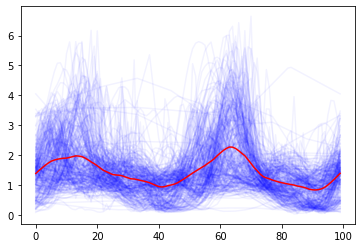

In [4]:
#Visualize some data points
with tables.open_file(train_data_path, mode='r') as file:
    subset = file.root.data[0:300, :, -1].T
    print(subset.shape)
    plt.plot(subset, color='b', alpha=0.05)
    plt.plot(np.mean(subset, axis=1), color ='r')

In [4]:
#Look at our label file
def get_age_table():
    table_folder = "/scratch/PI/euan/projects/mhc/data/tables"
    table_path = os.path.join(table_folder, 'cardiovascular-NonIdentifiableDemographicsTask-v2.tsv')

    df = pd.read_csv(table_path, sep='\t')
    df = df[['healthCode', 
             'NonIdentifiableDemographics.json.patientCurrentAge',
             'NonIdentifiableDemographics.patientCurrentAge']]
    
    print(f"Starting with {df.shape[0]} records")
    
    #Encode to bytes
    df['healthCode'] = df['healthCode'].map(lambda x: x.encode('UTF-8'))

    #Merge age columns
    df['Age'] = df['NonIdentifiableDemographics.patientCurrentAge'].fillna(df['NonIdentifiableDemographics.json.patientCurrentAge'])
    df = df[['healthCode', 'Age']]

    df = df.dropna()
    print(f"Dropping NaNs gives {df.shape[0]} users")

    #Drop duplicates
    df = df.set_index('healthCode')
    df = df.loc[~df.index.duplicated(keep='last')]
    print(f"Dropping duplicate healthcodes gives {df.shape[0]} users")


    df = df[df['Age'] > 18]
    df = df[df['Age'] < 100]
    print(f"Dropping invalid ages (less than 18 or greater than 100) gives {df.shape[0]} users")
            
    return df

label_df = get_age_table()

#Access a label like this
print(label_df.loc[label_df.index[0], 'Age'])

/home/users/danjwu/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Starting with 48655 records
Dropping NaNs gives 38460 users
Dropping duplicate healthcodes gives 21562 users
Dropping invalid ages (less than 18 or greater than 100) gives 20870 users
33.0


Starting with 48655 records
Dropping NaNs gives 38460 users
Dropping duplicate healthcodes gives 21562 users
Dropping invalid ages (less than 18 or greater than 100) gives 20870 users
(83, 1, 4, 100)


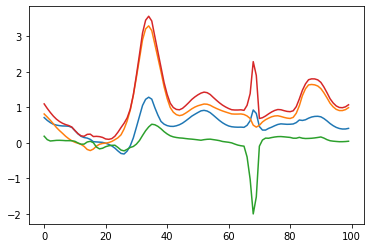

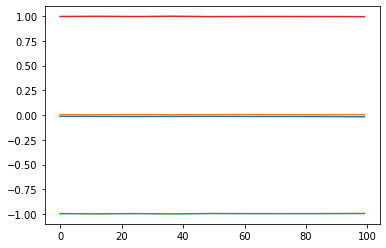

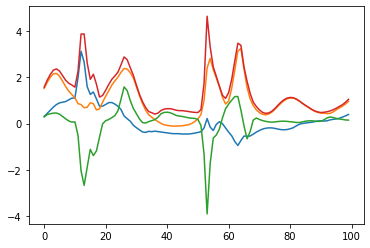

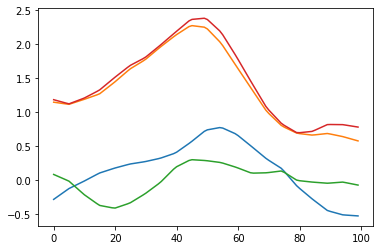

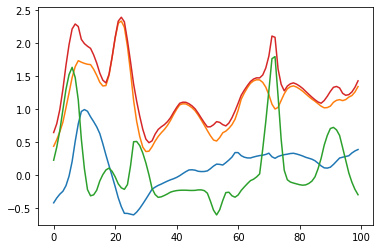

In [5]:
# =============================================================================
# Data generator
# =============================================================================
class SixMWTSequence(keras.utils.Sequence):
    '''
    SixMWTSequence
    Extends keras inbuilt sequence to create a data generator
    Saves on RAM by loading data from hdf5 files in memory
    Shuffle increases read time by 20x but makes the batches mixed
    '''
    def __init__(self, data_file, batch_size, label_df, shuffle=True, val=False, val_split = 0.7):
        #Open up file
        #self.lock = threading.Lock()
        self.data = data_file.root.data
        self.labels = data_file.root.labels
        
        self.age_cutoffs = [30, 40, 50, 60]
        self.num_bins = len(self.age_cutoffs) + 1

        #Track labels and batch size
        self.label_map = label_df
        self.batch_size = batch_size
        self.inval_hc = set()
        self.val = val
        self.val_split = val_split
        
        #Partition the dataset into train/test
        if val:
            num_data = int(self.labels.shape[0] * (1-val_split))
            self.order = np.arange(self.labels.shape[0] - num_data, self.labels.shape[0])
        else:
            num_data = int(self.labels.shape[0] * val_split)
            self.order = np.arange(num_data)
            
        self.length = num_data // self.batch_size
                
        #Shuffle
        if(shuffle):
            np.random.shuffle(self.order)        

    def __len__(self):

        return self.length
    
    def parse_label(self, code, label_df):
        """
        Helper function that parses the labels on survey data for a given code
        """
        try:
            age = label_df.loc[code, 'Age']
        except KeyError:
            return None

        for i in range(self.num_bins - 1):
            if age < self.age_cutoffs[i]:
                return i
            
        return self.num_bins - 1

    def __getitem__(self, idx):
        
        start_idx = idx*self.batch_size
        stop_idx = (idx + 1)*self.batch_size
                    
        idxs = self.order[start_idx:stop_idx]
        
        #Get the batch members
        batch_x = []
        batch_y = []
        hcs = []
        for idx in idxs:
            new_label = self.parse_label(self.labels[idx], self.label_map)
            if new_label is not None:
                batch_x.append(self.data[idx])
                batch_y.append(new_label)
                hcs.append(self.labels[idx])
                
            else:
                self.inval_hc.add(self.labels[idx])
                
        #Convert to numpy
        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        hcs = np.array(hcs)
                
        #Normalize over time dimension
        #print(np.mean(batch_x, axis = -2))

        #batch_x -= np.expand_dims(np.mean(batch_x, axis = 1), axis=1)
        #batch_x = keras.utils.normalize(batch_x, axis=2)
        #print(np.mean(batch_x, axis = -2))
        
        #Make categorical
        batch_y = to_categorical(batch_y, num_classes = self.num_bins)
            
        #Add a extra dimension
        batch_x = np.expand_dims(batch_x, axis=1)
        #Swap axes
        batch_x = np.swapaxes(batch_x, -1, -2)
            
        return batch_x, batch_y, hcs

label_df = get_age_table()
#Look at what the data file looks like
with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)    
    print(train_gen[20][0].shape)
    window = train_gen[20][0]
    
    for i in range(5):
        plt.figure()
        plt.plot(window[i, :, :].squeeze().T)
        plt.show()

In [12]:
#Test something dumb real fast
from scipy.signal import argrelmax, argrelmin
idx = 0
count = 0
while idx < window.shape[0]:
    data = window[idx, :, -1, :].squeeze()
    while len(argrelmax(data)[0]) < 3 or len(argrelmin(data)[0]) < 3 or (max(data) - min(data)) < 0.5:
        idx += 1
        data = window[idx, :, -1, :].squeeze()
    #plt.figure()
    #plt.plot(data.T)
    #plt.show()
    idx += 1
    count += 1

In [14]:
idx

83

In [17]:
#Make a baby validation dataset
X_val = np.empty((0, 1, 4, 100))
y_val = np.empty((0, 5))
hcs_val = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    val_gen = SixMWTSequence(file, batch_size, label_df, val=True)  
    for batch_x, batch_y, hcs in val_gen:
        X_val = np.concatenate((X_val, batch_x), axis=0)
        y_val = np.concatenate((y_val, batch_y), axis=0)
        hcs_val = np.concatenate((hcs_val, hcs))

In [19]:
#Make a baby train dataset in memory
X_train = np.empty((0, 1, 4, 100))
y_train = np.empty((0, 5))
hcs_train = np.empty((0,))

with tables.open_file(train_data_path, mode='r') as file:
    train_gen = SixMWTSequence(file, batch_size, label_df, val=False)  
    for batch_x, batch_y, hcs in train_gen:
        X_train = np.concatenate((X_train, batch_x), axis=0)
        y_train = np.concatenate((y_train, batch_y), axis=0)
        hcs_train = np.concatenate((hcs_train, hcs))

In [20]:
# Sanity Check
print(train_gen.inval_hc, val_gen.inval_hc)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)
print(np.unique(y_train))

{b'4e199c89-d1f8-420c-8793-7e229d255b1b', b'82d5ad5c-bb23-4b51-8626-43d718f7ee0c', b'6e7d43e1-07cc-43dd-9435-19dc466ee228', b'26c136c7-b7d2-4c29-9036-95ba9e94d5d7', b'f1650864-5242-42a1-9890-f718c5ec67ad', b'c202c975-16c2-4054-8981-43d75631df7e', b'29ba2fdd-2095-4395-96c7-b6e8aa3f53d2', b'9ea81387-a0fd-4b23-92b9-5d55f216c276', b'a74f543b-49fe-46c5-9923-7a9fa839513f', b'acf195d4-0bf9-4f9d-bdc3-deaf4e0d07e7', b'3ad7c195-bfc6-4b86-a3cc-bb3d0371d675', b'ace25575-2e55-4647-b22f-922615331682', b'09fb4fac-0d16-4bd8-9d32-0b8aeb5eafde', b'a1f0e617-3bf4-4355-b089-09ddf3fe364c', b'e56bc838-24bb-415c-a0ee-cc52c39b8acb', b'72ee3fd6-eecb-4317-a226-c070dda0d2a9', b'70d232d3-cdca-4a0e-897e-9516aabf9910', b'eb3750f7-f0d5-45b1-b9af-41a11faa8a18', b'bed83530-885a-446e-933d-ff892ca39ac0', b'e00cc943-36dd-47f2-a9ab-99e73c039f80', b'e4ba2adb-6e87-46d9-973e-d14be1776baa', b'ac6c6f4e-9342-4b19-98ca-55c2ad67ba89', b'5265658f-51e2-48f4-9846-67bcc2a04801', b'7ee88448-bbeb-45a6-8f9a-eede72dd52e4', b'9004767b-a3e7

In [24]:
# profile the dataset
from collections import Counter
xs = []
ys = []
print(list(Counter(list(y_train)).items()))
for item in Counter(list(y_train)).items():
    xs.append(item[0])
    ys.append(item[1])

plt.figure()
plt.title("Samples per BMI group (Training)")
#plt.bar(xs, ys)
plt.hist(y_train)
plt.xlim([0, 50])
plt.xlabel("BMI")
plt.ylabel("# Walk Cycles")
plt.show()

plt.figure()
plt.title("Samples per BMI group (Validation)")
#plt.bar(xs, ys)
plt.hist(y_val)
plt.xlim([0, 50])
plt.xlabel("BMI")
plt.ylabel("# Walk Cycles")
plt.show()

TypeError: unhashable type: 'numpy.ndarray'

In [25]:
# Save and export the data
np.save('BMI_binned_X_train.npy', X_train)
np.save('BMI_binned_X_val.npy', X_val)
np.save('BMI_binned_y_train.npy', y_train)
np.save('BMI_binned_y_val.npy', y_val)

# Training

In [3]:
#Load data
X_train = np.load('BMI_binned_X_train.npy')
y_train = np.load('BMI_binned_y_train.npy')

X_val = np.load('BMI_binned_X_val.npy')
y_val = np.load('BMI_binned_y_val.npy')

In [8]:
#Load 15 axis data
print('Beginning loading')
X_train = np.load('age_X_15.npy')
y_train = np.load('age_y_15.npy')
ids_train = np.load('age_ids_15.npy')

print('Finished loading')

print('Beginning age binning')

young_idxs = y_train < 30
old_idxs = y_train > 60
y_train[young_idxs] = 0
y_train[old_idxs] = 1

include_idxs = np.logical_or(young_idxs, old_idxs)
X_train = X_train[include_idxs]
y_train = y_train[include_idxs]
ids_train = ids_train[include_idxs]
      
print('Beginning X_train axis adjustment')

#Change X_train to weird format
X_train = np.expand_dims(X_train, 1)
X_train = np.swapaxes(X_train, -1, -2)

#Randomize
if False:
    print('Data will be randomized.')
    idxs = np.arange(X_train.shape[0])
    np.random.shuffle(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]
    ids_train = ids_train[idxs]
else:
    print('Data is NOT randomized.')

print('Beginning data splitting')

split_num = int(0.8*X_train.shape[0])
X_val = X_train[split_num:]
y_val = y_train[split_num:]
ids_val = ids_train[split_num:]

X_train = X_train[:split_num]
y_train = y_train[:split_num]
ids_train = ids_train[:split_num]

X_train.shape, X_val.shape, y_train.shape, y_val.shape, ids_train.shape, ids_val.shape

Beginning loading
Finished loading
Beginning age binning
Beginning X_train axis adjustment
Data is NOT randomized.
Beginning data splitting


((951296, 1, 15, 100),
 (237824, 1, 15, 100),
 (951296,),
 (237824,),
 (951296,),
 (237824,))

In [8]:
#Define a model
def get_model():
    model = Sequential()
    # ENTRY LAYER
    model.add(Conv1D(32, 10, activation='relu', input_shape=(100, 4)))
    model.add(BatchNormalization())

    for i in range(5):
    
        model.add(Conv1D(64, 5, activation='relu'))
        model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())

    model.add(Conv1D(128, 10, activation='relu'))
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(40, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(4, activation='softmax'))
    
    return model

In [23]:
def get_model():
    from keras import regularizers
    model = Sequential()
    # ENTRY LAYER
    model.add(Permute((1, 3, 2), input_shape=(1, 4, 100)))
    model.add(Conv2D(32, (1, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    for i in range(1,9):
    
        model.add(Conv2D(32*(2**(int(i/3))), (1, 3), padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.001)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
        if i%2 == 0:
            model.add(MaxPooling2D((1, 2)))

    model.add(Flatten())
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dropout(0.3))

    model.add(Dense(4, activation='softmax'))
    
    return model

In [22]:
import functools
import json

import keras.backend as K

from keras.layers import Permute, Dense, Input, Conv2D, concatenate, MaxPooling2D
from keras.layers import ELU, BatchNormalization, Dropout, GlobalAveragePooling2D
from keras.models import Model

# %load model_util
from keras.layers import Input
from keras.regularizers import l2


REG_P = dict(kernel_regularizer=l2(0))


def _create_input(input_shape, input_tensor=None, name='input'):
    """
    Select a correct input tensor based on shape and instance specification.

    # Arguments
        input_shape: Input shape tuple
        input_tensor: Existing tensor to wrap into the `Input` layer.
                      If set, the layer will not create a placeholder tensor.
        name: Name string for layer.

    # Returns
        Input Tensor
    """
    if input_tensor is None:
        return Input(shape=input_shape, name=name)

    if not K.is_keras_tensor(input_tensor):
        return Input(tensor=input_tensor, shape=input_shape, name=name)

    return input_tensor


def _conv_block(units, block=1, layer=1, sensor='acc'):
    """
    Create VGG style convolutional block.

    Deviations from original paper.
        - Remove `Dropout`
        - Added `BatchNormalization`
        - He-normal initialization
        - Uses `ELU` Activation
        
    # Arguments
        units: conv filters
        block: block number within network (used for naming)
        layer: layer number within block (used for naming)
        sensor: sensor name (used for naming)
        
    # Returns
        callable
    """
    def layer_wrapper(inp):
        x = Conv2D(units, (1, 3), padding='same', kernel_initializer='he_normal',
                   name=f'block{block}_conv{layer}_{sensor}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'block{block}_bn{layer}_{sensor}')(x)
        x = ELU(name=f'block{block}_act{layer}_{sensor}')(x)
        return x

    return layer_wrapper


def _dense_block(units, dropout=0.3, name='fc1'):
    """
    Create VGG fully connected block.

    # Deviations from original paper.
        - Added `BatchNormalization`
        - Uses `ELU` Activation
    
    # Arguments
        units: fc layer dimensionality
        dropout: dropout probability
        name: prefix for dense layers

    # Returns
        callable
    """

    def layer_wrapper(inp):
        x = Dense(units, name=f'{name}', **REG_P)(inp)
        x = BatchNormalization(epsilon=0.23, name=f'{name}_bn')(x)
        x = ELU(name=f'{name}_act')(x)
        x = Dropout(dropout, name=f'{name}_dropout')(x)
        return x

    return layer_wrapper


def _vgg_body(factor=2, sensor='acc'):
    """
    VGG Network Body containing convolutional blocks
    
    # Arguments
        factor: scaling factor to reduce network filter width
        sensor: sensor name
        
    # Return
        callable
    """

    _vgg_conv_block = functools.partial(_conv_block, sensor=sensor)

    def layer_wrapper(inp):
        x = Permute((1, 3, 2), name=f'swapaxes_{sensor}')(inp)

        # Block 1
        x = _vgg_conv_block(64 // factor, block=1, layer=1)(x)
        x = _vgg_conv_block(64 // factor, block=1, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block1_pool_{sensor}')(x)

        # Block 2
        x = _vgg_conv_block(128 // factor, block=2, layer=1)(x)
        x = _vgg_conv_block(128 // factor, block=2, layer=2)(x)
        x = MaxPooling2D((1, 2), name=f'block2_pool_{sensor}')(x)

        # Block 3
        x = _vgg_conv_block(256 // factor, block=3, layer=1)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=2)(x)
        x = _vgg_conv_block(256 // factor, block=3, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block3_pool_{sensor}')(x)

        # Block 4
        x = _vgg_conv_block(512 // factor, block=4, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=4, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block4_pool_{sensor}')(x)

        # Block 5
        x = _vgg_conv_block(512 // factor, block=5, layer=1)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=2)(x)
        x = _vgg_conv_block(512 // factor, block=5, layer=3)(x)
        x = MaxPooling2D((1, 2), name=f'block5_pool_{sensor}')(x)

        return x

    return layer_wrapper

def VGG16Net(input_shape=None, input_tensor=(None, None),
             classes=1000, dropout=0.3, factor=2):
    """
    Modified VGG architecture
        https://arxiv.org/abs/1409.1556

    # Arguments
        input_shape: shape tuple
        input_tensor: Keras tensor (i.e. output of `layers.Input()`) to use as image input for the model.
        classes: optional number of classes to classify images
        dropout: dropout applied to fc layers
        factor: scaling factor to reduce network filter width

    # Returns
        A Keras model instance.
    """
    assert input_shape or all(input_tensor), f'Must provide at least one: input_shape, input_tensor'

    # Two Inputs
    img_input_acc = _create_input(input_shape, input_tensor=input_tensor[0], name='acc_input')

    # Accelerometer and Gyroscope Conv Blocks
    x = _vgg_body(factor=factor, sensor='acc')(img_input_acc)

    # Merge and Pool Channels
    x = GlobalAveragePooling2D(name='avgpool')(x)

    # FC Layers
    x = _dense_block(4098 // factor, dropout=dropout, name='fc1')(x)
    x = _dense_block(4098 // factor, dropout=dropout, name='fc2')(x)

    # Classification block
    if classes == 2:
        x = Dense(1, activation = 'sigmoid', name='predictions')(x)
    else:
        x = Dense(classes, activation='softmax', name='predictions')(x)

    return Model(img_input_acc, x, name='VGG16Net')

from keras.callbacks import ModelCheckpoint

class MultiGPUCheckpoint(ModelCheckpoint):
    """
    Drop in replacement for `ModelCheckpoint` callback which fixes a bug
    when saving models wrapped in `keras.utils.multi_gpu_model`.

    Please see:
        https://github.com/keras-team/keras/issues/8123#issuecomment-409395274

    Works with both single and multi-gpu configurations.
    """
    def set_model(self, model):
        layer = model.layers[-2]
        if isinstance(layer, Model) and layer.input_names == model.input_names:
            self.model = layer
        else:
            self.model = model
                

In [23]:
#Set the model up
#model = get_model()
model = VGG16Net(input_shape=(1, 15, 100), classes=2)
print(model.summary())

#Define optimizer
adam = keras.optimizers.Adam() #Default lr is 0.001

model.compile(loss='binary_crossentropy', #'categorical_crossentropy',
              optimizer=adam,
              metrics=model_metrics)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
acc_input (InputLayer)       (None, 1, 15, 100)        0         
_________________________________________________________________
swapaxes_acc (Permute)       (None, 1, 100, 15)        0         
_________________________________________________________________
block1_conv1_acc (Conv2D)    (None, 1, 100, 32)        1472      
_________________________________________________________________
block1_bn1_acc (BatchNormali (None, 1, 100, 32)        128       
_________________________________________________________________
block1_act1_acc (ELU)        (None, 1, 100, 32)        0         
_________________________________________________________________
block1_conv2_acc (Conv2D)    (None, 1, 100, 32)        3104      
_________________________________________________________________
block1_bn2_acc (BatchNormali (None, 1, 100, 32)        128       
__________

In [24]:
#Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=2, min_lr=1e-7, verbose=1)

early_stop = EarlyStopping(patience=8, verbose=1, restore_best_weights=True)

#tb = TensorBoard(log_dir=os.path.join(output_dir, 'logs'), 
#                 write_graph=False,) 
                 #histogram_freq=5, 
                 #embeddings_freq=5, 
                 #embeddings_layer_names=['fc1'],
                 #mbeddings_data = X_val)

cb_list = []#[reduce_lr, early_stop, tb]

In [25]:
history = model.fit(x = X_train,
                    y = y_train,
                    epochs=5,
                    validation_data = (X_val, y_val),
                    callbacks = cb_list,
                    shuffle=True, 
                    batch_size = batch_size)

Train on 951296 samples, validate on 237824 samples
Epoch 1/5
951296/951296 [==============================] - 117s 123us/step - loss: 2.5435 - acc: 0.7268 - sensitivity: 0.8278 - specificity: 0.5700 - fpr: 0.4300 - fnr: 0.1722 - precision: 0.7511 - f1: 0.7866 - val_loss: 0.7792 - val_acc: 0.6757 - val_sensitivity: nan - val_specificity: nan - val_fpr: nan - val_fnr: nan - val_precision: 0.6192 - val_f1: nan
Epoch 2/5
951296/951296 [==============================] - 110s 116us/step - loss: 0.5261 - acc: 0.7947 - sensitivity: 0.8611 - specificity: 0.6923 - fpr: 0.3077 - fnr: 0.1389 - precision: 0.8140 - f1: 0.8362 - val_loss: 1.7044 - val_acc: 0.4182 - val_sensitivity: nan - val_specificity: nan - val_fpr: nan - val_fnr: nan - val_precision: nan - val_f1: nan
Epoch 3/5
951296/951296 [==============================] - 110s 116us/step - loss: 0.7245 - acc: 0.7688 - sensitivity: 0.8339 - specificity: 0.6683 - fpr: 0.3317 - fnr: 0.1661 - precision: 0.7993 - f1: 0.8144 - val_loss: 1.0468 - v

# Visualize Results

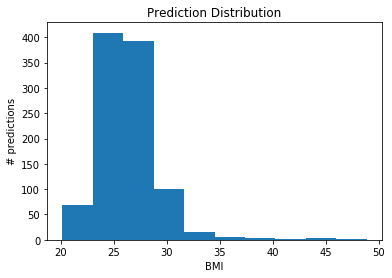

In [34]:
#Example predictions
pred = model.predict(X_val, batch_size = batch_size)

plt.figure()
plt.title('Prediction Distribution')
plt.xlabel('BMI')
plt.ylabel('# predictions')
plt.hist(pred)
plt.show()

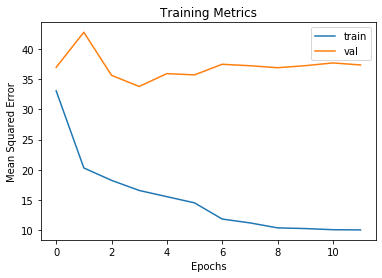

In [35]:
plt.figure()
plt.plot(history.history['mean_squared_error'], label='train')
plt.plot(history.history['val_mean_squared_error'], label='val')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training Metrics')
plt.show()

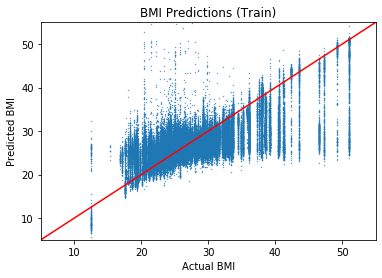

In [55]:
y_pred = model.predict(X_train, batch_size = batch_size)
#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,25)) 
df_results=pd.DataFrame(data=np.column_stack((y_train,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
plt.title("BMI Predictions (Train)")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.show()

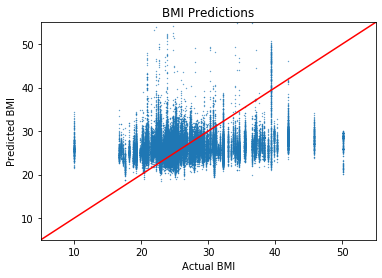

In [47]:
y_pred = model.predict(X_val, batch_size = batch_size)

#Print confusion matrix
import seaborn as sns
fig, ax = plt.subplots(figsize=(25,25)) 
df_results=pd.DataFrame(data=np.column_stack((y_val,y_pred.round())),columns=['True','Predicted'])
CT_results=pd.crosstab(df_results["True"], df_results["Predicted"]).apply(lambda r: r/r.sum(), axis=1)

#Make a heatmap
sns.heatmap(CT_results, annot=True, fmt=".2f", linewidths=.5,ax=ax)
plt.title("BMI Predictions (Validation)")
plt.xlabel("Actual BMI")
plt.ylabel("Predicted BMI")
plt.show()

# That's it folks!

In [ ]:
#Save the model
model.save("BMI_binned_15.h5")